In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from scipy import interpolate
import matplotlib
matplotlib.rcParams['font.family']='Malgun Gothic'
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [3]:
forecast_weather = pd.read_csv('../../Data\\capstone\\weather/solar_forecast_weather.csv')
solar = pd.read_csv('../../Data\\capstone\\weather/solar_power_2204.csv')
real_weather = pd.read_csv('../../Data/capstone/total_eda_real.csv')
solar_2 = pd.read_csv('../../Data/capstone/발전소/하동_eda.csv')

In [4]:
def time_change(data, Forecast_time):
    """
    data = forecast가 있는 데이터
    Forecast_time = 예보시간

    return = 예보시간을 기준으로 데이터를 정렬한 데이터
    """
    data[Forecast_time] = pd.to_datetime(data[Forecast_time])
    data['real_time'] = data.apply(lambda row: row['Forecast time'] + datetime.timedelta(hours=row['forecast']), axis=1)
    forecast_weather_eda = data.groupby(['real_time']).mean().drop('forecast', axis=1)
    forecast_weather_eda.reset_index(inplace=True)
    return forecast_weather_eda

In [5]:
solar['datetime'] = pd.to_datetime(solar['datetime'])
solar.target.replace(65535.0, solar.target.mean(), inplace=True)
solar['month'] = solar.datetime.dt.month
solar['hour'] = solar.datetime.dt.hour
solar['year'] = solar.datetime.dt.year
solar['day'] = solar.datetime.dt.day
solar_eda = solar.groupby(['year','month','day','hour']).sum().reset_index()
solar_eda['date'] = pd.to_datetime(solar_eda[['year', 'month', 'day', 'hour']])

In [6]:
eda_forecast = time_change(forecast_weather, 'Forecast time')

In [7]:
reg = real_weather[real_weather['지점명'] =='순천']

In [8]:
eda_weather = reg.drop(['지점', '지점명'], axis=1)
eda_weather['일시'] = pd.to_datetime(eda_weather['일시'])
eda_weather['hour'] = eda_weather['일시'].dt.hour
eda_weather['month'] = eda_weather['일시'].dt.month
eda_weather['year'] = eda_weather['일시'].dt.year

In [9]:
eda_weather.set_index('일시', inplace=True)

In [10]:
total_time = pd.date_range(start='2021-01-01 00:00:00', end='2022-04-30 23:00:00', freq='H')

In [11]:
solar_2

,date,hour,value
0,2013-01-01 01:00:00,1,0.0
1,2013-01-01 02:00:00,2,0.0
2,2013-01-01 03:00:00,3,0.0
3,2013-01-01 04:00:00,4,0.0
4,2013-01-01 05:00:00,5,0.0
...,...,...,...
83227,2022-06-30 20:00:00,20,7.6
83228,2022-06-30 21:00:00,21,0.0
83229,2022-06-30 22:00:00,22,0.0
83230,2022-06-30 23:00:00,23,0.0


In [12]:
solar_2.date = pd.to_datetime(solar_2.date)

In [13]:
solar_2.set_index('date', inplace=True)

In [14]:
x = eda_weather.loc['2021-01-01 00:00:00' : '2022-04-30 23:00:00']

In [15]:
y = solar_2.loc['2021-01-01 00:00:00' : '2022-04-30 23:00:00']

In [16]:
y.drop('hour', axis=1 , inplace=True)

In [17]:
x.drop(['위도','경도'], axis=1, inplace=True)

In [18]:
total = pd.concat([x, y], axis = 1)

In [19]:
total.interpolate(method = 'linear', inplace = True)

In [20]:
y = total.value / 5
x = total.drop('value', axis=1)

In [21]:
slice = 455 * 24

In [22]:
x_train = x.iloc[:slice]
x_test = x.iloc[slice:]
y_train = y.iloc[:slice]
y_test = y.iloc[slice:]

sc_x = StandardScaler()
sc_y = StandardScaler()

In [23]:
sc_x = MinMaxScaler()
sc_y = MinMaxScaler()

In [24]:
sc_x.fit(x_train)

x_train = sc_x.transform(x_train)
x_test = sc_x.transform(x_test)

In [25]:
sc_y.fit(y_train.values.reshape(-1,1))

y_train = sc_y.transform(y_train.values.reshape(-1,1))
y_train = y_train.flatten()

In [26]:
y_test = sc_y.transform(y_test.values.reshape(-1,1))

In [27]:
print(x_train.shape)
print(x_test.shape)

(10920, 8)
(720, 8)


----
# Model Train

In [28]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

In [29]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM


In [30]:
dt = DecisionTreeRegressor(max_depth=5)

In [31]:
svm_params = {
    "kernel" : ['rbf', 'linear'],
    "C" : [0.01, 0.1, 1],
    "gamma" : [0.01, 0.1, 1]
}

In [32]:
params = {
    'n_estimators' : [5,50,100],
    'max_depth': [3,5,7],
    'min_samples_leaf':[4,6],
    'min_samples_split':[4,8,16]
}

In [33]:
lg_params = {
    'n_estimators' : [5,10,15],
    'max_depth': [3,5,8],
    'learning_rate' : [0.01, 0.1, 0.3],
    'num_leaves' : [16, 32, 64],
    'verbose': [-1]
}

In [34]:
rf = RandomForestRegressor()
et = ExtraTreesRegressor()
svr = SVR()

In [35]:
grid_cv_rf = GridSearchCV(rf, param_grid=params,
                      cv=3, n_jobs=-1)
grid_cv_rf.fit(x_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7], 'min_samples_leaf': [4, 6],
                         'min_samples_split': [4, 8, 16],
                         'n_estimators': [5, 50, 100]})

In [36]:
grid_cv_et = GridSearchCV(et, param_grid=params,
                      cv=3, n_jobs=-1)
grid_cv_et.fit(x_train, y_train)

GridSearchCV(cv=3, estimator=ExtraTreesRegressor(), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7], 'min_samples_leaf': [4, 6],
                         'min_samples_split': [4, 8, 16],
                         'n_estimators': [5, 50, 100]})

In [37]:
grid_cv_svr = GridSearchCV(svr, param_grid=svm_params,cv=3, n_jobs=-1)
grid_cv_svr.fit(x_train, y_train)

GridSearchCV(cv=3, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1], 'gamma': [0.01, 0.1, 1],
                         'kernel': ['rbf', 'linear']})

----

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)

optimizer =  tf.keras.optimizers.Adam(learning_rate=0.001)

# LSTM 모델 정의
lstm_model = Sequential()
lstm_model.add(LSTM(64, input_shape=(11, 1), return_sequences=True))
lstm_model.add(LSTM(128))
lstm_model.add(Dense(24))
lstm_model.compile(loss='mse', optimizer = optimizer, metrics=['mse'])

-----
# Model Prediction

In [38]:
window_size = 24 * 365

In [39]:
from tqdm import tqdm

In [40]:
grid_cv_rf.best_estimator_.fit(x_train[:window_size], y_train[:window_size])
grid_cv_et.best_estimator_.fit(x_train[:window_size], y_train[:window_size])
grid_cv_svr.best_estimator_.fit(x_train[:window_size], y_train[:window_size])
#lstm_model.fit(x_train[:window_size].reshape(-1,11,1), y_train[:window_size], epochs=240, batch_size=24)

SVR(C=1, gamma=1)

In [41]:
predictions_list = []

x_train_copy = x_train.copy()
y_train_copy = y_train.copy()

for i in tqdm(range(0, len(x_test), 24)):
    x_test_window = x_test[i:i+24]
    y_test_window = y_test[i:i+24]

    predictions_rf = grid_cv_rf.best_estimator_.predict(x_test_window)
    predictions_et = grid_cv_et.best_estimator_.predict(x_test_window)
    predictions_svr = grid_cv_svr.best_estimator_.predict(x_test_window)
    #predictions_lstm = lstm_model.predict(x_test_window)

    for j in range(24):
        # predictions_list.append([predictions_rf[j], predictions_et[j], predictions_lg[j], predictions_lstm[0][j]])
        predictions_list.append([predictions_rf[j], predictions_et[j], predictions_svr[j]])

    x_train_copy = np.concatenate((x_train_copy, x_test_window), axis=0)
    y_train_copy = np.concatenate((y_train_copy, y_test_window.ravel()), axis=0)

    grid_cv_rf.best_estimator_.fit(x_train[i+24:i+24+window_size], y_train_copy[i+24:i+24+window_size])
    grid_cv_et.best_estimator_.fit(x_train[i+24:i+24+window_size], y_train_copy[i+24:i+24+window_size])
    grid_cv_svr.best_estimator_.fit(x_train[i+24:i+24+window_size], y_train_copy[i+24:i+24+window_size])
    # lstm_model.fit(x_train[i+24:i+24+window_size].reshape(-1,11,1), y_train_copy[i+24:i+24+window_size], epochs=240, verbose=0, batch_size=24)

predictions_array = np.array(predictions_list)

100%|██████████| 30/30 [00:44<00:00,  1.49s/it]


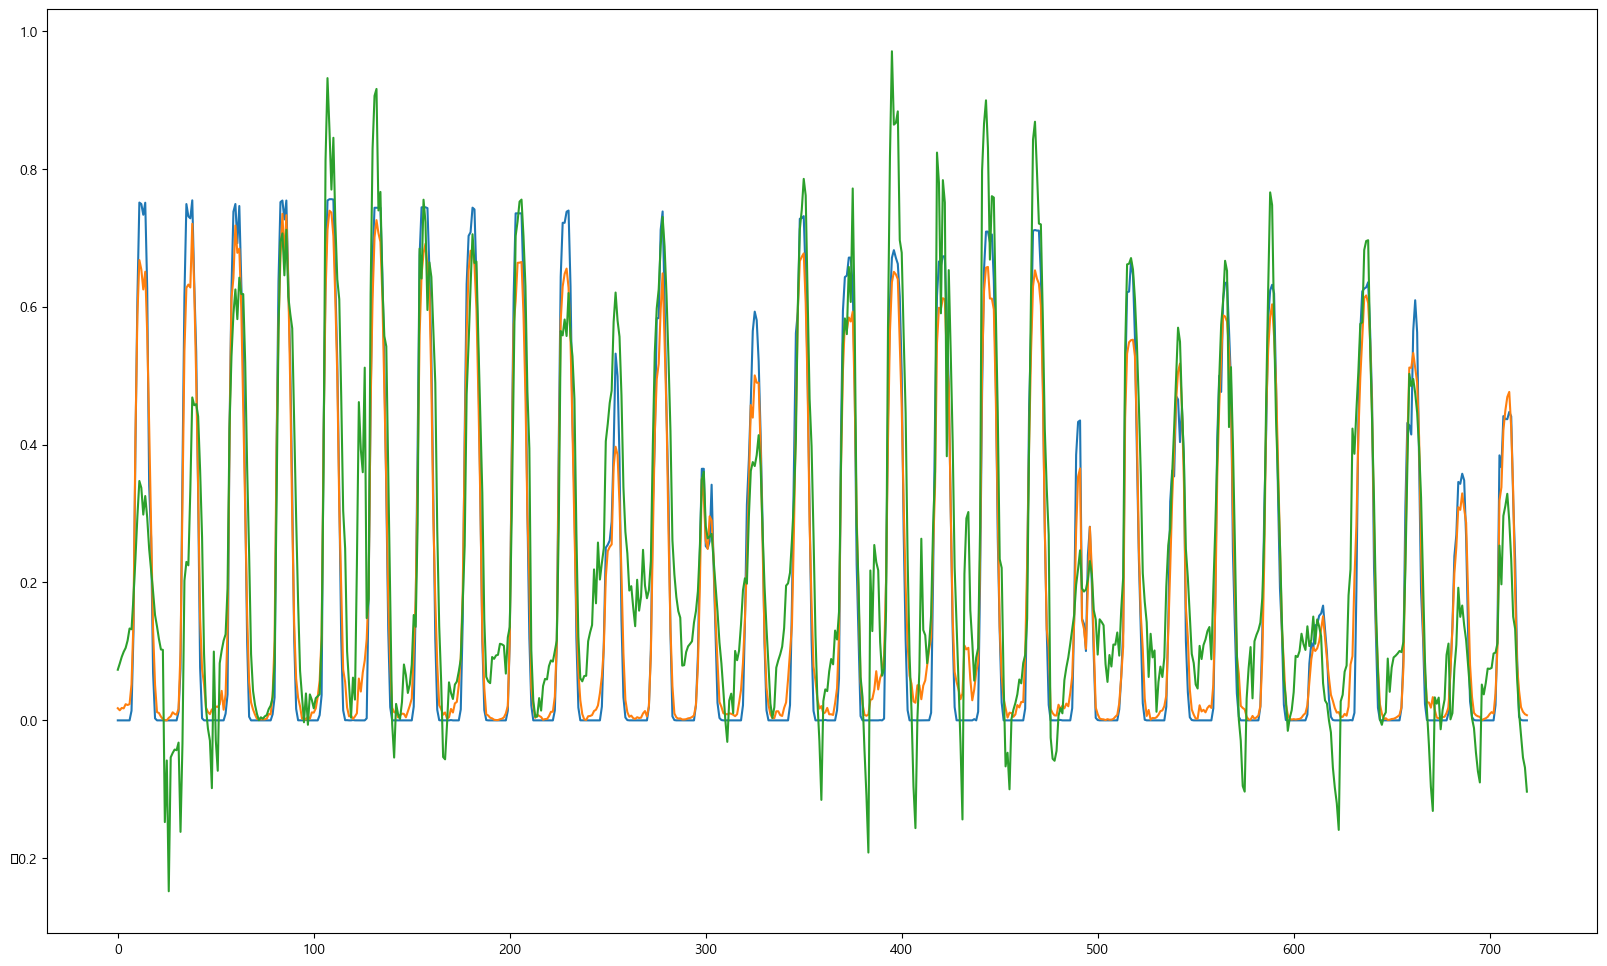

In [42]:
plt.figure(figsize=(20,12))
plt.plot(predictions_list)

In [43]:
from math import *
import random
import sys

In [44]:
class Particle:
    def __init__(self, max_iter, initial_position=None):
        if initial_position:  # If an initial position is provided
            self.position = initial_position.copy()
        else:
            self.position = [0.0]*3  # particle current position
        self.velocity = [random.uniform(-1, 1) for _ in range(24)]  # particle current velocity
        self.best_position = [0.0]*3  # particle best position
        self.fitness = sys.maxsize   # particle fitness
        self.best_fitness = sys.maxsize  # particle best fitness
        self.iteration = 0  # iteration count
        self.max_iter = max_iter

    def evaluate_fitness(self, fitness_func):
        self.fitness = fitness_func(self.position)
        if self.fitness < self.best_fitness:
            self.best_position = self.position.copy()
            self.best_fitness = self.fitness

    def update_velocity(self, global_best_position):
        w_min = 0.5
        w_max = 1
        self.iteration += 1
        w = w_max - ((w_max - w_min) * self.iteration / self.max_iter)
        c1 = 1
        c2 = 1.5
        for i in range(len(self.position)):
            r1 = random.random()
            r2 = random.random()
            cognitive_velocity = c1 * r1 * (self.best_position[i] - self.position[i])
            social_velocity = c2 * r2 * (global_best_position[i] - self.position[i])
            self.velocity[i] = w * self.velocity[i] + cognitive_velocity + social_velocity

    def update_position(self, bounds):
        for i in range(len(self.position)):
            self.position[i] += self.velocity[i]
            if self.position[i] < bounds[i][0]:
                self.position[i] = bounds[i][0]
            elif self.position[i] > bounds[i][1]:
                self.position[i] = bounds[i][1]

class PSO:
    def __init__(self, fitness_function, bounds, num_particles, max_iter, initial_positions=None):
        self.fitness_func = fitness_function
        self.bounds = bounds
        self.num_particles = num_particles
        self.max_iter = max_iter
        self.global_best_position = [0.0]*24
        self.global_best_fitness = sys.maxsize
        if initial_positions:
            self.swarm = [Particle(max_iter, initial_position=pos) for pos in initial_positions]
        else:
            self.swarm = [Particle(max_iter) for _ in range(num_particles)]

    def run_result(self):
        for i in range(self.max_iter):
            for j in range(self.num_particles):
                self.swarm[j].evaluate_fitness(self.fitness_func)
                if self.swarm[j].fitness < self.global_best_fitness:
                    self.global_best_position = self.swarm[j].position.copy()
                    self.global_best_fitness = self.swarm[j].fitness
            for j in range(self.num_particles):
                self.swarm[j].update_velocity(self.global_best_position)
                self.swarm[j].update_position(self.bounds)
        return self.global_best_position, self.global_best_fitness

lstm_model.fit(x_train[:window_size].reshape(-1, 8, 1), y_train[:window_size], epochs=100, verbose=0)

****
# Meta model Train

In [45]:
from sklearn.linear_model import LinearRegression

In [46]:
grid_cv_rf.best_estimator_.fit(x_train[:window_size], y_train[:window_size])
grid_cv_et.best_estimator_.fit(x_train[:window_size], y_train[:window_size])
grid_cv_svr.best_estimator_.fit(x_train[:window_size], y_train[:window_size])
#lstm_model.fit(x_train[:window_size].reshape(-1,11,1), y_train[:window_size], epochs=240, batch_size=24)

SVR(C=1, gamma=1)

In [47]:
train_predictions_list = []

# 훈련 데이터에 대한 예측 수집
for i in range(0, len(x_train), 24):
    x_train_window = x_train[i:i+24]

    train_predictions_rf = grid_cv_rf.best_estimator_.predict(x_train_window)
    train_predictions_et = grid_cv_et.best_estimator_.predict(x_train_window)
    train_predictions_svr = grid_cv_svr.best_estimator_.predict(x_train_window)

    # auto_arima_model.fit(y_train[:i+24])
    # train_predictions_lstm = lstm_model.predict(x_train_window)

    for j in range(24):
        # train_predictions_list.append([train_predictions_rf[j], train_predictions_et[j], train_predictions_lg[j], train_predictions_lstm[0][j]])
        train_predictions_list.append([train_predictions_rf[j], train_predictions_et[j], train_predictions_svr[j]])

In [48]:
train_predictions_array = np.array(train_predictions_list)

In [49]:
def fitness_function(x, train_predictions_array, y_train):
    fitness = 0
    for i in range(3):
        fitness += train_predictions_array[:,i] * x[i]
    difference = y_train - fitness
    return np.sum(difference**2)

In [50]:
weights = np.array([3 if 11 <= i <= 13 else 1 for i in range(24)])

def weighted_fitness_function(x, train_predictions_array, y_train, weights):
    fitness = 0
    for i in range(3):
        fitness += train_predictions_array[:,i] * x[i]
    difference = y_train - fitness
    num_repeats = len(difference) // len(weights)
    extended_weights = np.tile(weights, num_repeats)
    weighted_difference = difference * extended_weights  # Corrected the weights shape here
    return np.sum(weighted_difference**2)


In [51]:
bound = [(-10,10) for _ in range(3)]

In [52]:
pso_result = PSO(lambda x : weighted_fitness_function(x, train_predictions_array, y_train, weights),
                 bounds=bound,
                 num_particles=250,
                 max_iter=1000)


pso_result = PSO(lambda x : fitness_function(x, train_predictions_array, y_train), bounds=bound,num_particles=200, max_iter=500 )

In [53]:
best_position_price, best_fitness_price = pso_result.run_result()

In [54]:
best_position_price

[0.9070964021249327, -0.024344799390548292, 0.15655606078900947]

In [55]:
optimal_result = (train_predictions_array * best_position_price).sum(axis=1)

In [56]:
from sklearn.metrics import mean_absolute_error

In [57]:
mean_absolute_error(y_train, optimal_result)

0.05338948869942126

In [58]:
meta_model = LinearRegression()

In [59]:
meta_model.fit(train_predictions_array, y_train)

LinearRegression()

In [60]:
meta_model.coef_

array([ 0.97685593, -0.09886663,  0.14302076])

----
# Meta model prediction

In [61]:
meta_result = meta_model.predict(predictions_array)

In [62]:
meta_result_2 = np.dot(best_position_price, predictions_array.T)

In [63]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

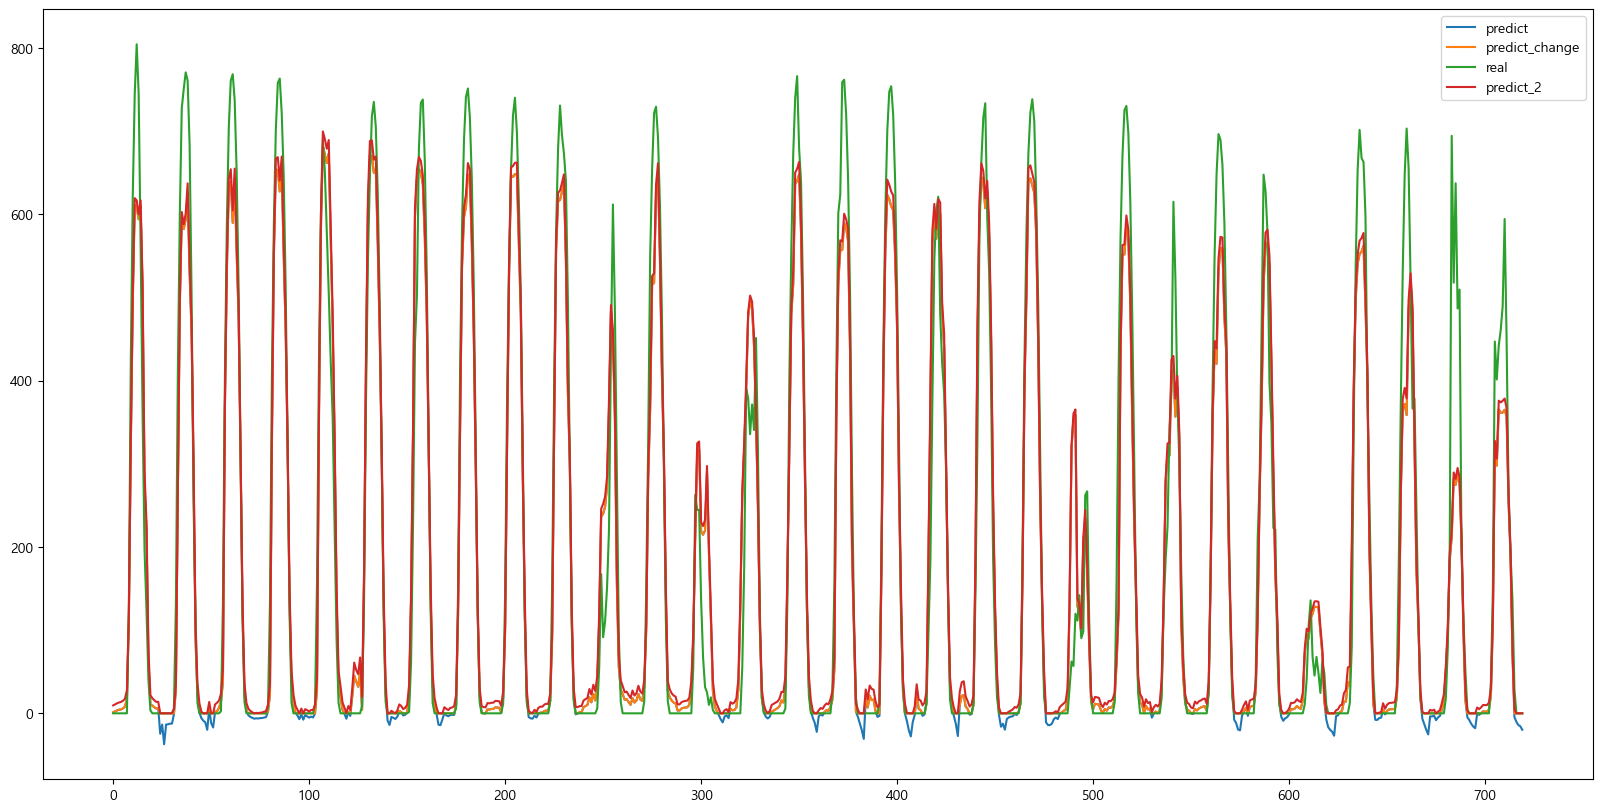

In [64]:
plt.figure(figsize=(20, 10))
plt.plot(np.arange(len(meta_result)), sc_y.inverse_transform(meta_result.reshape(-1,1)), label='predict')
plt.plot(np.arange(len(meta_result)), np.maximum(sc_y.inverse_transform(meta_result.reshape(-1,1)),0), label='predict_change')
plt.plot(np.arange(len(meta_result)), sc_y.inverse_transform(y_test), label='real')
plt.plot(np.arange(len(meta_result)), np.maximum(sc_y.inverse_transform(meta_result_2.reshape(-1,1)),0), label='predict_2')
plt.legend()
plt.show()

In [65]:
print('mse error (linear regression) : ',mean_squared_error(y_test, meta_result))
print('mae error (linear regression) : ',mean_absolute_error(y_test, meta_result))
print('mape error (linear regression) : ',mean_absolute_percentage_error(y_test, meta_result))

print('----------------------------------------------------')

print('mse error (PSO optimization) : ',mean_squared_error(y_test, meta_result_2))
print('mae error (PSO optimization) : ',mean_absolute_error(y_test, meta_result_2))
print('mape error (PSO optimization) : ',mean_absolute_percentage_error(y_test, meta_result_2))

mse error (linear regression) :  0.007127126316374303
mae error (linear regression) :  0.050190508954652886
mape error (linear regression) :  21293858196740.215
----------------------------------------------------
mse error (PSO optimization) :  0.006756481027722569
mae error (PSO optimization) :  0.050655605034633684
mape error (PSO optimization) :  30837442673835.277


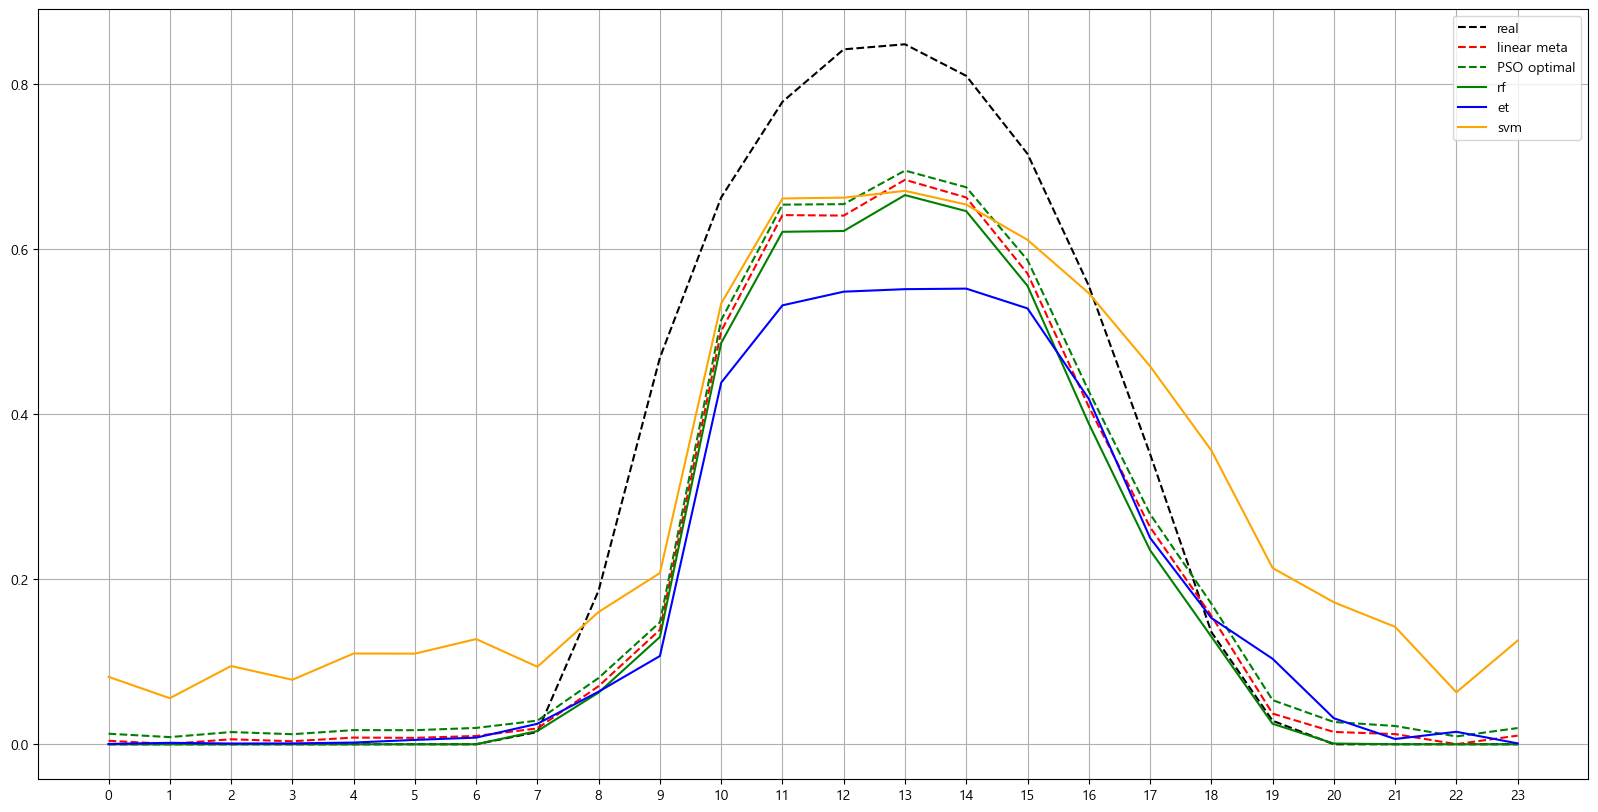

0.07288597816716347

In [66]:
i = 21
plt.figure(figsize=(20,10))
plt.plot(np.arange(24), y_test[i * 24 : 24*(i+1)], 'k--')
plt.plot(np.arange(24), meta_result[i * 24 : 24*(i+1)], 'r--')
plt.plot(np.arange(24), meta_result_2[i * 24 : 24*(i+1)], 'g--')

plt.plot(np.arange(24), pd.DataFrame(predictions_array).iloc[i * 24 : 24*(i+1),0], color = 'green')
plt.plot(np.arange(24), pd.DataFrame(predictions_array).iloc[i * 24 : 24*(i+1),1], color = 'blue')
plt.plot(np.arange(24), pd.DataFrame(predictions_array).iloc[i * 24 : 24*(i+1),2], color = 'orange')

plt.legend(['real','linear meta', 'PSO optimal','rf', 'et', 'svm'])
plt.xticks(np.arange(24))
plt.grid()
plt.show()

mean_absolute_error(y_test[i * 24 : 24*(i+1)], meta_result[i * 24 : 24*(i+1)])

# MAP